In [34]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from plotly.graph_objects import Figure, Scatter
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

plt.rcParams['figure.figsize'] = [20, 5]

In [35]:
df = pd.read_parquet('data/2_preprocessed/preprocessed_sales.parquet')
df.head().T

,0,1,2,3,4
row_id,42433,22253,48883,11731,22255
order_id,AG-2011-2040,IN-2011-47883,HU-2011-1220,IT-2011-3647632,IN-2011-47883
order_date,2011-01-01 00:00:00,2011-01-01 00:00:00,2011-01-01 00:00:00,2011-01-01 00:00:00,2011-01-01 00:00:00
ship_date,2011-06-01 00:00:00,2011-08-01 00:00:00,2011-05-01 00:00:00,2011-05-01 00:00:00,2011-08-01 00:00:00
ship_mode,Standard Class,Standard Class,Second Class,Second Class,Standard Class
customer_id,TB-11280,JH-15985,AT-735,EM-14140,JH-15985
customer_name,Toby Braunhardt,Joseph Holt,Annie Thurman,Eugene Moren,Joseph Holt
segment,Consumer,Consumer,Consumer,Home Office,Consumer
city,Constantine,Wagga Wagga,Budapest,Stockholm,Wagga Wagga
state,Constantine,New South Wales,Budapest,Stockholm,New South Wales


In [36]:
ts = df.groupby('order_date')['profit'].sum().sort_index()

<AxesSubplot:xlabel='order_date'>

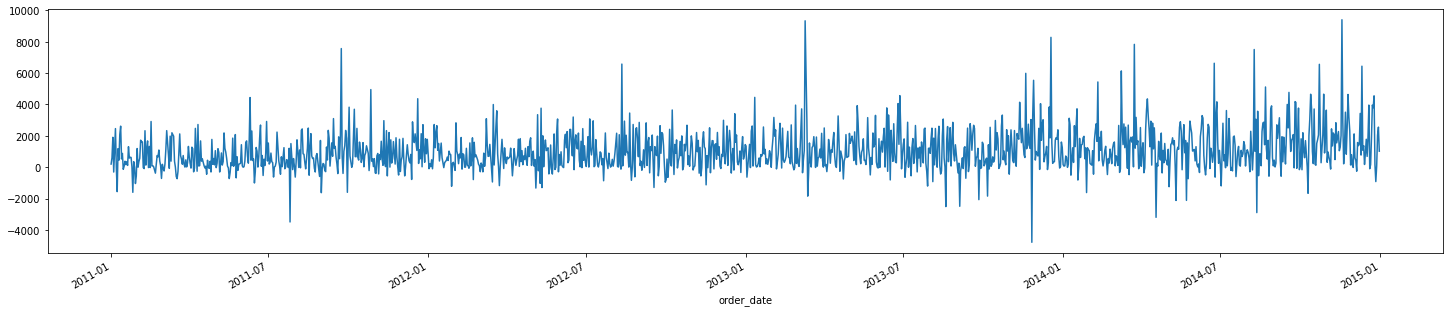

In [37]:
ts.plot(figsize=(25, 5))

<AxesSubplot:xlabel='order_date'>

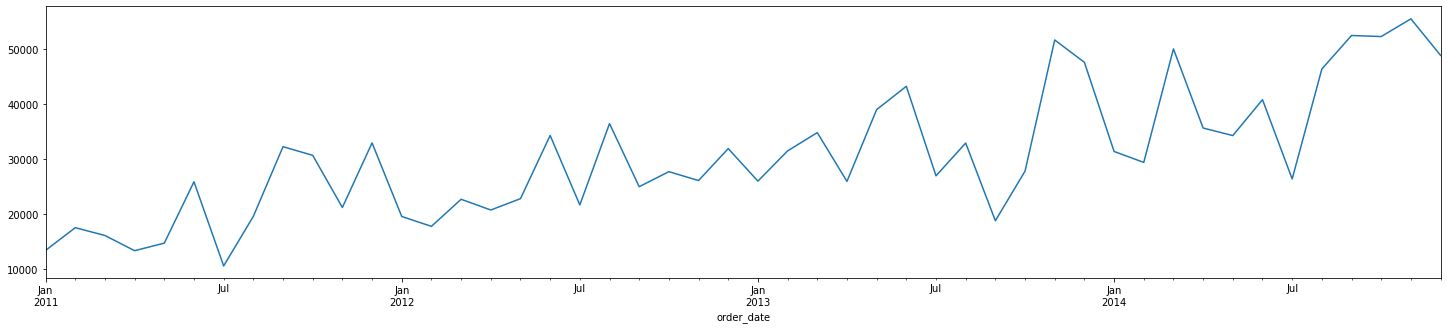

In [38]:
ts.resample('M').sum().plot(figsize=(25, 5))

<AxesSubplot:xlabel='order_date'>

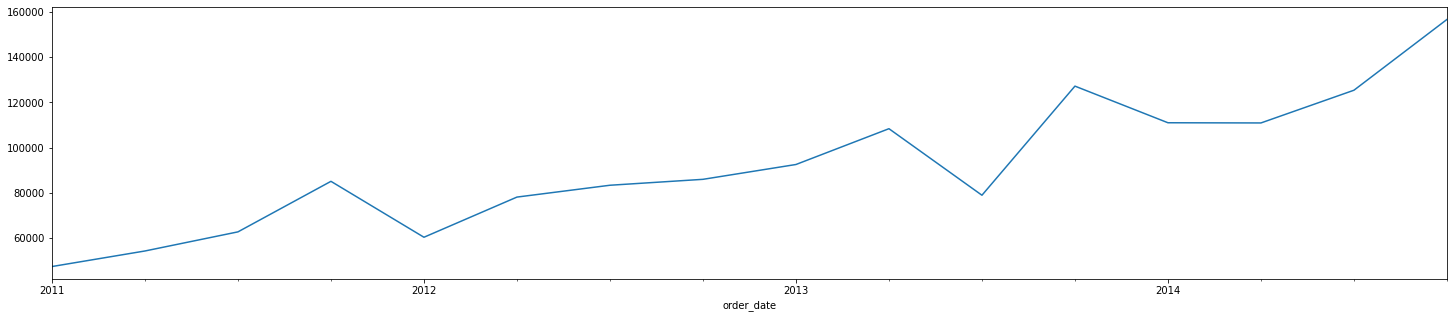

In [39]:
ts.resample('Q').sum().plot(figsize=(25, 5))

<AxesSubplot:xlabel='order_date'>

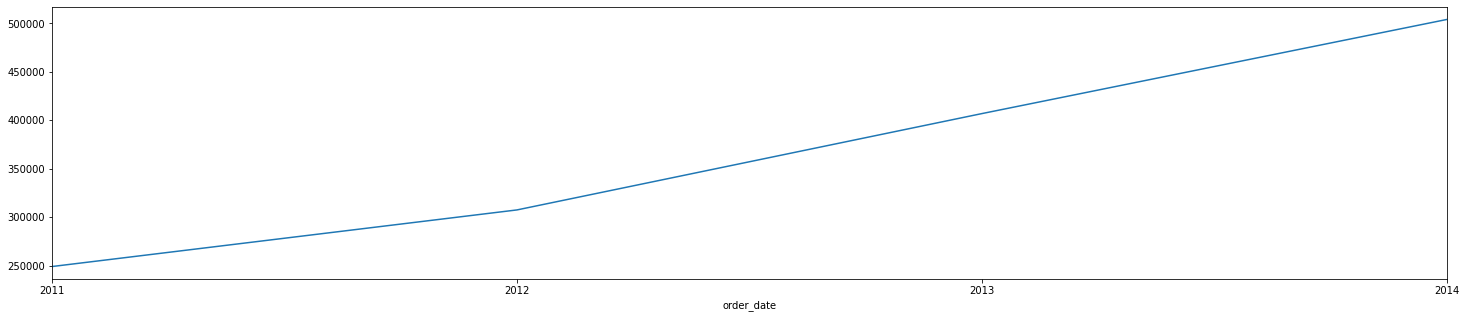

In [40]:
ts.resample('Y').sum().plot(figsize=(25, 5))

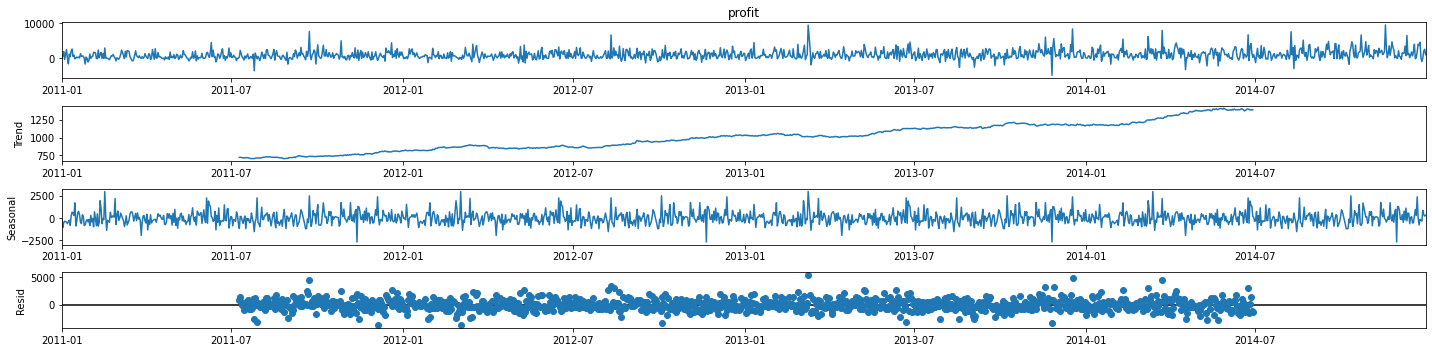

In [41]:
seasonal_decompose(x=ts, model='additive', period=365).plot();

# Prophet

In [42]:
data = (ts
         .to_frame()
         .reset_index()
         .rename(columns={'order_date': 'ds', 'profit': 'y'}))
data.head()

,ds,y
0,2011-01-01,198.8730
1,2011-01-02,603.4736
2,2011-01-03,1905.1539
3,2011-01-04,-308.7874
4,2011-01-06,2460.2536


In [43]:
y_train = data[:-30]
y_train.tail()

,ds,y
1395,2014-11-27,2320.81980
1396,2014-11-28,140.18242
1397,2014-11-29,795.53720
1398,2014-11-30,124.14200
1399,2014-12-01,-16.28400


In [44]:
y_test = data[-30:]
y_test.head()

,ds,y
1400,2014-12-02,2121.65540
1401,2014-12-03,598.27660
1402,2014-12-04,421.13000
1403,2014-12-05,-256.02130
1404,2014-12-06,1572.70816


In [45]:
model = Prophet()
model.fit(y_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [46]:
future = model.make_future_dataframe(periods=len(y_test))

forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-01,561.033896,-1016.671135,2236.048705,561.033896,561.033896,-16.500008,-16.500008,-16.500008,-145.748625,-145.748625,-145.748625,129.248617,129.248617,129.248617,0.0,0.0,0.0,544.533888
1,2011-01-02,561.641179,-1337.114798,1728.377395,561.641179,561.641179,-356.547072,-356.547072,-356.547072,-466.853724,-466.853724,-466.853724,110.306653,110.306653,110.306653,0.0,0.0,0.0,205.094108
2,2011-01-03,562.248463,-746.999637,2467.421555,562.248463,562.248463,268.461971,268.461971,268.461971,178.835091,178.835091,178.835091,89.626879,89.626879,89.626879,0.0,0.0,0.0,830.710434
3,2011-01-04,562.855747,-765.289654,2461.653256,562.855747,562.855747,232.271523,232.271523,232.271523,164.806593,164.806593,164.806593,67.464930,67.464930,67.464930,0.0,0.0,0.0,795.127271
4,2011-01-06,564.070315,-917.433480,2368.262800,564.070315,564.070315,134.750086,134.750086,134.750086,114.792244,114.792244,114.792244,19.957843,19.957843,19.957843,0.0,0.0,0.0,698.820402


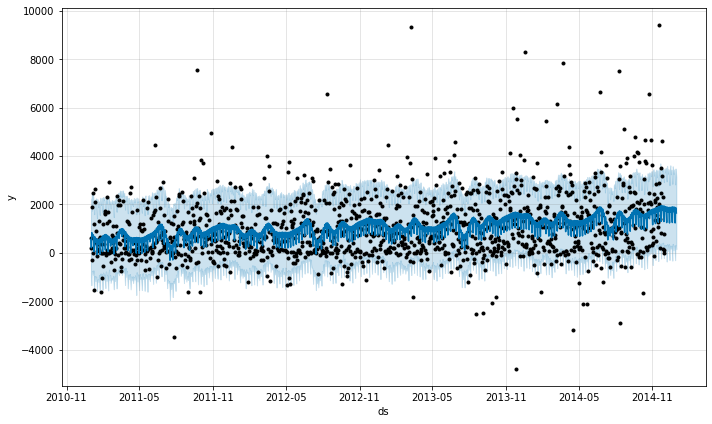

In [47]:
model.plot(forecast);

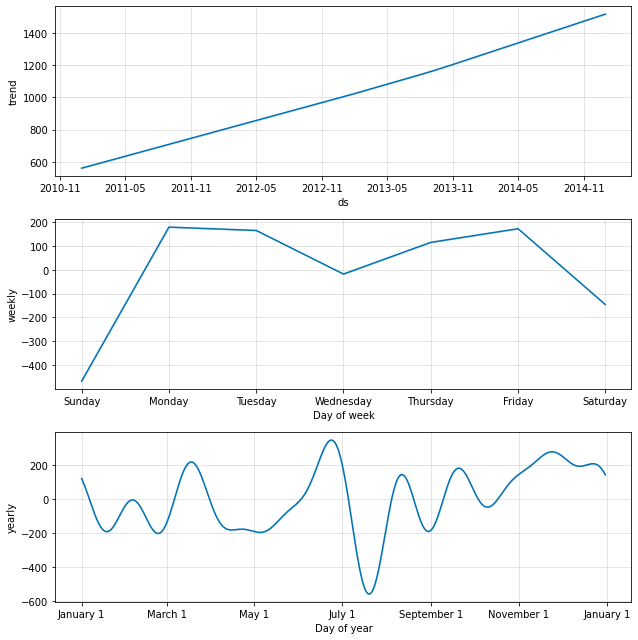

In [48]:
model.plot_components(forecast);

# Model evaluation

In [49]:
forecast_data = forecast.set_index('ds').loc[:, ['yhat', 'yhat_lower', 'yhat_upper']]
forecast_data = forecast_data.loc[(forecast_data.index >= y_test['ds'].min()) & (forecast_data.index <= y_test['ds'].max()), ['yhat', 'yhat_lower', 'yhat_upper']]

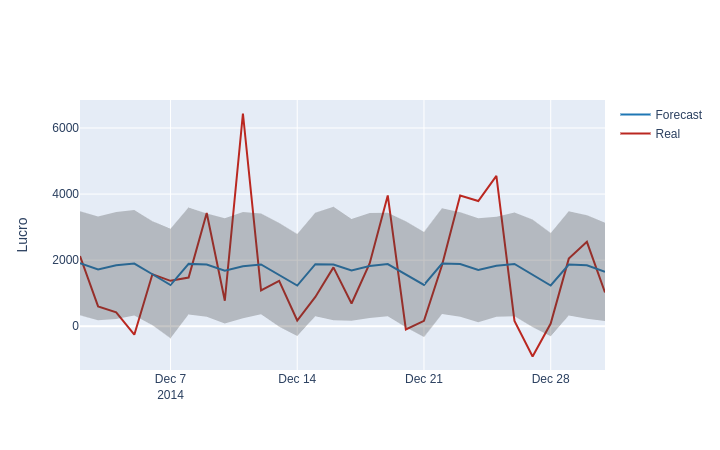

In [50]:
fig = Figure([
    Scatter(
        name='Real',
        x=y_test['ds'],
        y=y_test['y'],
        mode='lines',
        line=dict(color='rgb(186, 39, 32)'),
    ),
    
    Scatter(
        name='Forecast',
        x=forecast_data.index,
        y=forecast_data['yhat'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    Scatter(
        name='Upper Bound',
        x=forecast_data.index,
        y=forecast_data['yhat_upper'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    Scatter(
        name='Lower Bound',
        x=forecast_data.index,
        y=forecast_data['yhat_lower'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
])

fig.update_layout(
    yaxis_title='Lucro',
    hovermode="x"
)
fig.show()

In [51]:
mean_squared_error(y_test['y'], forecast_data['yhat'])

2407913.4056762685

In [52]:
mean_absolute_percentage_error(y_test['y'], forecast_data['yhat'])

2.6837610599049513

# Next 30 days forecasting

In [53]:
data = (ts
         .to_frame()
         .reset_index()
         .rename(columns={'order_date': 'ds', 'profit': 'y'}))
data.tail()

,ds,y
1425,2014-12-27,-916.64004
1426,2014-12-28,81.06380
1427,2014-12-29,2046.20678
1428,2014-12-30,2554.00460
1429,2014-12-31,1020.17080


In [54]:
model = Prophet()
model.fit(data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [55]:
future = model.make_future_dataframe(periods=30)

forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1455,2015-01-26,1513.443189,21.235832,3178.637612,1513.430074,1513.459234,52.228298,52.228298,52.228298,174.571800,174.571800,174.571800,-122.343502,-122.343502,-122.343502,0.0,0.0,0.0,1565.671487
1456,2015-01-27,1514.121308,-83.972077,3138.083999,1514.107463,1514.139454,82.796225,82.796225,82.796225,188.365807,188.365807,188.365807,-105.569582,-105.569582,-105.569582,0.0,0.0,0.0,1596.917533
1457,2015-01-28,1514.799428,-145.310412,3046.912213,1514.784714,1514.819476,-112.252273,-112.252273,-112.252273,-23.596436,-23.596436,-23.596436,-88.655838,-88.655838,-88.655838,0.0,0.0,0.0,1402.547155
1458,2015-01-29,1515.477548,-57.700344,3068.308385,1515.460945,1515.499580,73.353728,73.353728,73.353728,145.453086,145.453086,145.453086,-72.099358,-72.099358,-72.099358,0.0,0.0,0.0,1588.831276
1459,2015-01-30,1516.155667,116.510843,3202.943084,1516.137326,1516.178919,105.112152,105.112152,105.112152,161.496905,161.496905,161.496905,-56.384753,-56.384753,-56.384753,0.0,0.0,0.0,1621.267819


In [56]:
forecast_data = forecast[-30:]
forecast_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1430,2015-01-01,1496.490198,291.868230,3396.136245,1496.490198,1496.490198,274.887694,274.887694,274.887694,145.453086,145.453086,145.453086,129.434607,129.434607,129.434607,0.0,0.0,0.0,1771.377892
1431,2015-01-02,1497.168317,260.555604,3422.053891,1497.168317,1497.168317,269.533428,269.533428,269.533428,161.496905,161.496905,161.496905,108.036524,108.036524,108.036524,0.0,0.0,0.0,1766.701746
1432,2015-01-03,1497.846437,-65.975659,3022.774533,1497.846437,1497.846437,-79.568586,-79.568586,-79.568586,-164.578522,-164.578522,-164.578522,85.009937,85.009937,85.009937,0.0,0.0,0.0,1418.277851
1433,2015-01-04,1498.524557,-531.833276,2590.796720,1498.524557,1498.524557,-421.045904,-421.045904,-421.045904,-481.712640,-481.712640,-481.712640,60.666736,60.666736,60.666736,0.0,0.0,0.0,1077.478652
1434,2015-01-05,1499.202676,140.175040,3383.429539,1499.202676,1499.202676,209.934421,209.934421,209.934421,174.571800,174.571800,174.571800,35.362621,35.362621,35.362621,0.0,0.0,0.0,1709.137097


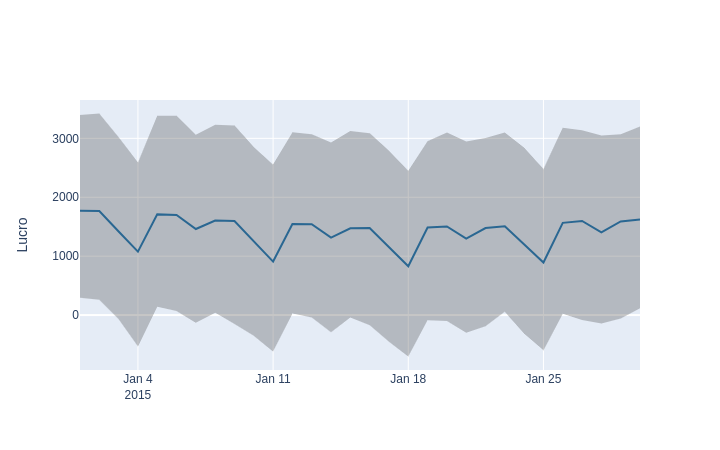

In [57]:
fig = Figure([
    Scatter(
        name='Forecast',
        x=forecast_data['ds'],
        y=forecast_data['yhat'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
        showlegend=False
    ),
    Scatter(
        name='Upper Bound',
        x=forecast_data['ds'],
        y=forecast_data['yhat_upper'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    Scatter(
        name='Lower Bound',
        x=forecast_data['ds'],
        y=forecast_data['yhat_lower'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
])

fig.update_layout(
    yaxis_title='Lucro',
    hovermode="x"
)
fig.show()

In [62]:
forecast_data.set_index('ds')[['yhat_lower', 'yhat_upper', 'yhat']]

,yhat_lower,yhat_upper,yhat
ds,,,
2015-01-01,291.868230,3396.136245,1771.377892
2015-01-02,260.555604,3422.053891,1766.701746
2015-01-03,-65.975659,3022.774533,1418.277851
2015-01-04,-531.833276,2590.796720,1077.478652
2015-01-05,140.175040,3383.429539,1709.137097
2015-01-06,70.939000,3384.046766,1697.735881
2015-01-07,-131.935218,3060.482846,1460.427846
2015-01-08,38.907020,3231.070631,1604.416650
2015-01-09,-151.119147,3217.269780,1596.126756
